In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '/home/jbreda/PWM')
import PWM
import torch
import h5py

import matplotlib.pyplot as plt
import time

ModuleNotFoundError: No module named 'PWM'

In [ ]:
# args
threads = 24
genome = "mm10"
window_kb = 5
promoterome_bed = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm1kb_filtered.bed"
promoterome_hdf5 = f"/home/jbreda/Promoterome/results/{genome}/promoterome_pm1kb.hdf5"

# fix number of threads for torch
torch.set_num_threads(threads)

#infile_jaspar_clusters_to_tf = 'resources/interactive_trees/JASPAR_2022_matrix_clustering_vertebrates_CORE_tables/clusters_motif_names.tab'
#infile_jaspar_clusters_tf_corr = 'resources/interactive_trees/JASPAR_2022_matrix_clustering_vertebrates_CORE_tables/pairwise_compa.tab'
#clusters_to_tf = pd.read_csv(infile_jaspar_clusters_to_tf,sep='\t',header=None)
#clusters_tf_corr = pd.read_csv(infile_jaspar_clusters_tf_corr,sep='\t',low_memory=False)

# get promoterome and sequence
promoterome = pd.read_csv(promoterome_bed,sep='\t')
with h5py.File(promoterome_hdf5, 'r') as promoterome_hdf5:
    Prom_seq = torch.from_numpy(promoterome_hdf5['sequence'][:]).float()

# get pwm_matrix
PWMs = PWM.get_PWM()
N_PWM = len(PWMs)
l_max=  max([PWMs[m].shape[0] for m in PWMs])
PWM_tensor = torch.zeros([N_PWM,l_max,4])
logZ = torch.zeros(N_PWM)
nuc_perm = np.eye(4).astype(bool)

for i in np.sort(list(PWMs.keys())):
    L = PWMs[i].shape[0]
    # recursive forward-backward algorithm
    # Z_l = Z_l-1 * [ sum_{i=1}^4 exp( w_l,i ) ]
    #Z_l_minus_1 = 1
    #for l in range(L):
    #    Z_l = Z_l_minus_1 * np.exp(PWM[i][l,:]).sum()
    # Z_l is 1 as np.exp(PWM[i][l,:]).sum() = 1 for any l

    # fill in tensor
    l_diff = (l_max - L)/2
    PWM_tensor[i,:,:] = torch.nn.functional.pad(torch.from_numpy(PWMs[i]),pad=(0,0,int(np.ceil(l_diff)),int(np.floor(l_diff))))
del PWMs

# get background frequency correspondiong to PWMs
background = np.log(PWM.get_background_frequency(genome))
PWM_background_tensor = np.zeros([N_PWM,l_max,4])
for i in range(PWM_tensor.shape[0]):
    idx_motif = PWM_tensor[i].sum(axis=1)!=0
    PWM_background_tensor[i,idx_motif,:] = background[None,:].repeat(idx_motif.sum(),axis=0)
PWM_background_tensor = torch.from_numpy(PWM_background_tensor).float()

# Select just a few promoters for testing. Here all Stat promoters.
idx = np.where(promoterome['gene'].str.contains('S'))[0]
print(f'number of promoters: {len(idx)}')
Prom_seq = Prom_seq[idx]



# input:   (batch_size, in_channels, input width)
# filters: (out_channels, in_channels​, kernel width)
convolution_bg = torch.exp( torch.nn.functional.conv1d( torch.transpose(Prom_seq,1,2), torch.transpose(PWM_background_tensor,1,2) ) )
convolution    = torch.exp( torch.nn.functional.conv1d( torch.transpose(Prom_seq,1,2), torch.transpose(PWM_tensor,1,2) ) )
# normalize for backgroud prob.
convolution /= convolution + convolution_bg
del convolution_bg
# normalize for each possible motif.
for p in range(convolution.shape[0]):
    convolution[p] /= convolution[p].sum(axis=0)



# do convolution motif by motif
l_valid_conv = Prom_seq.shape[1] - l_max + 1
convolution_bg_ = torch.zeros([Prom_seq.shape[0],N_PWM,l_valid_conv])
convolution_ = torch.zeros([Prom_seq.shape[0],N_PWM,l_valid_conv])
for i in range(N_PWM):
    convolution_bg_[:,i:i+1,:] = torch.exp( torch.nn.functional.conv1d( torch.transpose(Prom_seq,1,2), torch.transpose(PWM_background_tensor[i:i+1],1,2) ) )
    convolution_[:,i:i+1,:] = torch.exp( torch.nn.functional.conv1d( torch.transpose(Prom_seq,1,2), torch.transpose(PWM_tensor[i:i+1],1,2) ) )
convolution_ /= convolution_ + convolution_bg_
del convolution_bg_
# normalize for each possible motif.
for p in range(convolution_.shape[0]):
    convolution_[p] /= convolution_[p].sum(axis=0)



number of promoters: 2648
elapsed time: 3.654346466064453
elapsed time: 12.421849250793457
ratio: 3.0


TypeError: all() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [154]:
np.prod(np.array(convolution.shape))

3770788

In [131]:
def factorisation(n):
    fact = []
    i = 2
    while i<=n:
        if n%i==0:      
            fact.append(i)
            n//= i
        else:
            i+=1
    return fact

[137]
137


In [125]:
N_PWM

137

ValueError: x and y must have same first dimension, but have shapes (2, 269342) and (1,)

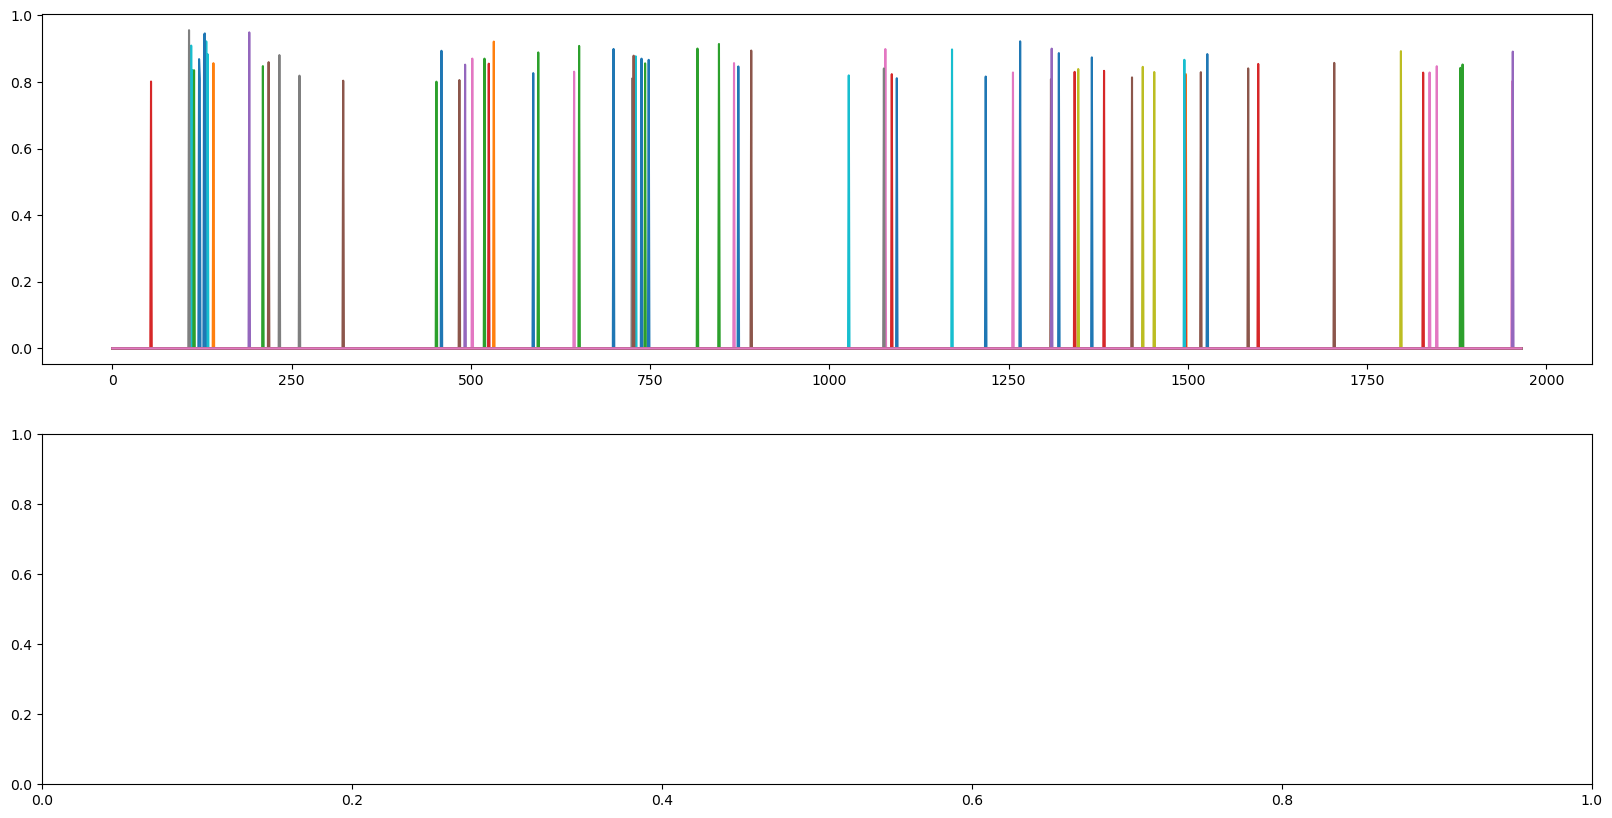

In [69]:
to_plot = convolution[0,:,:].T
to_plot[to_plot<0.8] = 0

fig, axes = plt.subplots(2,1,figsize=(20,10))

ax = axes[0]
ax.plot(to_plot)

ax = axes[1]
ax.plot( torch.sort(convolution[0,:,:].flatten()), torch.linspace(0,1,convolution[0,:,:].flatten().shape[0])[0] )

In [53]:
convolution.shape

torch.Size([14, 137, 1966])